In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
climate_merged = pd.read_excel(r'../../../../portugal/purchases_paper/datasets/climate_mun.xlsx',index_col=0 )
econ_data_q = pd.read_excel(r'../../../../portugal/purchases_paper/datasets/economic_data_q.xlsx',index_col=0 )

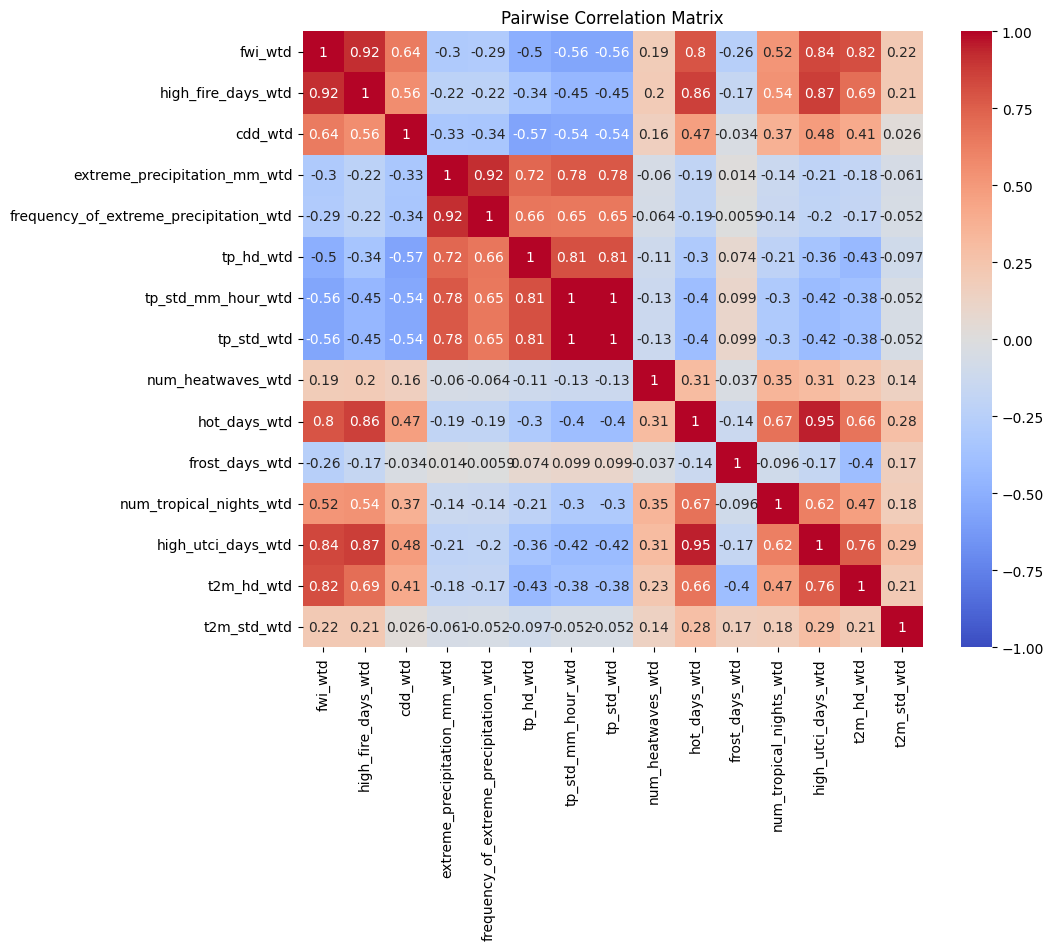

In [3]:
correl_data = climate_merged[[col for col in climate_merged.columns if col not in ['time', 'concelho']]]

# Compute the pairwise correlation matrix
corr_matrix = correl_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pairwise Correlation Matrix')
plt.show()

### Create Non Linear Weather Columns

In [4]:
climate_merged.columns = climate_merged.columns.str.replace(r'_wtd$', '', regex=True)


In [5]:
climate_merged['tp_2'] = climate_merged.groupby('concelho')['tp_hd'].transform(lambda x: x**2)
climate_merged['tp_3'] = climate_merged.groupby('concelho')['tp_hd'].transform(lambda x: x**3)
climate_merged['t2m_2'] = climate_merged.groupby('concelho')['t2m_hd'].transform(lambda x: x**2)
climate_merged['t2m_3'] = climate_merged.groupby('concelho')['t2m_hd'].transform(lambda x: x**3)


In [6]:
climate_merged.columns

Index(['concelho', 'time', 'fwi', 'high_fire_days', 'cdd',
       'extreme_precipitation_mm', 'frequency_of_extreme_precipitation',
       'tp_hd', 'tp_std_mm_hour', 'tp_std', 'num_heatwaves', 'hot_days',
       'frost_days', 'num_tropical_nights', 'high_utci_days', 't2m_hd',
       't2m_std', 'tp_2', 'tp_3', 't2m_2', 't2m_3'],
      dtype='object')

### First Differences


In [7]:
# df: original DataFrame with identifiers `concelho`, `time`
econ_data_q = econ_data_q.sort_values(['concelho', 'time'])


# Filter columns based on the exclusion criteria
vars_to_diff = [
    c for c in econ_data_q.columns 
    if c not in ['concelho', 'time']]
print(vars_to_diff)
econ_data_q_diff = (
    econ_data_q.groupby('concelho', group_keys=False)[vars_to_diff]
      .diff()
      .add_suffix('_D1')
)

econ_data_q = pd.concat([econ_data_q, econ_data_q_diff], axis=1)


['hpi', 'hpi_log', 'purchases', 'purchases_log', 'ur']


In [8]:
# df: original DataFrame with identifiers `concelho`, `time`
climate_merged = climate_merged.sort_values(['concelho', 'time'])


# Filter columns based on the exclusion criteria
vars_to_diff = [
    c for c in climate_merged.columns 
    if c not in ['concelho', 'time']]
print(vars_to_diff)
climate_merged_diff = (
    climate_merged.groupby('concelho', group_keys=False)[vars_to_diff]
      .diff()
      .add_suffix('_D1')
)

climate_merged = pd.concat([climate_merged, climate_merged_diff], axis=1)


['fwi', 'high_fire_days', 'cdd', 'extreme_precipitation_mm', 'frequency_of_extreme_precipitation', 'tp_hd', 'tp_std_mm_hour', 'tp_std', 'num_heatwaves', 'hot_days', 'frost_days', 'num_tropical_nights', 'high_utci_days', 't2m_hd', 't2m_std', 'tp_2', 'tp_3', 't2m_2', 't2m_3']


### Create Lags for Weather Variables

In [9]:

# Collect all new columns in a dictionary
lagged_columns = {}

for exog_var in [var for var in climate_merged.columns if var not in ['time', 'concelho']]:
    for i in range(1, 13):
        shift_var_name = f'{exog_var}_L{i}'
        lagged_columns[shift_var_name] = climate_merged.groupby('concelho')[exog_var].shift(i)

# Add all new columns to the DataFrame at once
climate_merged = pd.concat([climate_merged, pd.DataFrame(lagged_columns)], axis=1)

In [10]:
climate_merged

concelho       time        fwi  high_fire_days        cdd  \
0      abrantes 2006-01-01   3.060288        0.000000  13.000000   
1      abrantes 2006-02-01   3.349269        0.000000   7.942155   
2      abrantes 2006-03-01   3.311095        0.000000  12.000000   
3      abrantes 2006-04-01   8.096714        0.000000   7.975173   
4      abrantes 2006-05-01  35.935457       16.379892  28.741621   
...         ...        ...        ...             ...        ...   
56707   vouzela 2022-08-01        NaN             NaN  12.960684   
56708   vouzela 2022-09-01        NaN             NaN  13.000000   
56709   vouzela 2022-10-01        NaN             NaN  11.562532   
56710   vouzela 2022-11-01        NaN             NaN   3.000000   
56711   vouzela 2022-12-01        NaN             NaN   3.000000   

       extreme_precipitation_mm  frequency_of_extreme_precipitation     tp_hd  \
0                      0.000000                            0.000000 -0.579008   
1                      0.000000                            0.000000 -0.051960   
2                     53.215940                            2.688721  0.770818   
3                      0.000000                            0.000000 -0.220131   
4                      0.000000                            0.000000 -0.972203   
...                         ...                                 ...       ...   
56707                  0.000000                            0.000000 -1.893994   
56708                 53.961794                            1.426008 -0.071406   
56709                 22.613170                            0.506191  2.000237   
56710                 21.449835                            0.493809  2.541513   
56711                 82.345254                            1.506191  3.938583   

       tp_std_mm_hour     tp_std  ...  t2m_3_D1_L3  t2m_3_D1_L4  t2m_3_D1_L5  \
0            0.094483   2.267592  ...          NaN          NaN          NaN   
1            0.151207   3.628960  ...          NaN          NaN          NaN   
2            0.255780   6.138712  ...          NaN          NaN          NaN   
3            0.132959   3.191017  ...          NaN          NaN          NaN   
4            0.009924   0.238172  ...    26.822370          NaN          NaN   
...               ...        ...  ...          ...          ...          ...   
56707        0.013414   0.321926  ...    13.894410     1.442010     2.589306   
56708        0.336088   8.066115  ...     6.058209    13.894410     1.442010   
56709        0.520010  12.480239  ...   135.130271     6.058209    13.894410   
56710        0.436678  10.480281  ...   -65.899013   135.130271     6.058209   
56711        0.574312  13.783495  ...   -70.171796   -65.899013   135.130271   

       t2m_3_D1_L6  t2m_3_D1_L7  t2m_3_D1_L8  t2m_3_D1_L9  t2m_3_D1_L10  \
0              NaN          NaN          NaN          NaN           NaN   
1              NaN          NaN          NaN          NaN           NaN   
2              NaN          NaN          NaN          NaN           NaN   
3              NaN          NaN          NaN          NaN           NaN   
4              NaN          NaN          NaN          NaN           NaN   
...            ...          ...          ...          ...           ...   
56707    13.589012   -14.668718     4.329174    -9.827687    -16.311833   
56708     2.589306    13.589012   -14.668718     4.329174     -9.827687   
56709     1.442010     2.589306    13.589012   -14.668718      4.329174   
56710    13.894410     1.442010     2.589306    13.589012    -14.668718   
56711     6.058209    13.894410     1.442010     2.589306     13.589012   

       t2m_3_D1_L11  t2m_3_D1_L12  
0               NaN           NaN  
1               NaN           NaN  
2               NaN           NaN  
3               NaN           NaN  
4               NaN           NaN  
...             ...           ...  
56707    -34.118806     17.533814  
56708    -16.311833    -34.118806  
56709     -9.827687    -16.3118

### Convert Climate to Quarterly Data

In [11]:
# Ensure the 'time' column is in datetime format
climate_merged['time'] = pd.to_datetime(climate_merged['time'])

# Filter for years 2010 to 2022
climate_merged_slice = climate_merged[
    (climate_merged['time'] >= '2010-01-01') & (climate_merged['time'] <= '2022-12-31')
]

In [12]:
climate_merged_slice

concelho       time        fwi  high_fire_days        cdd  \
48     abrantes 2010-01-01   1.795309        0.000000   7.103404   
49     abrantes 2010-02-01   1.338550        0.000000   2.104760   
50     abrantes 2010-03-01   2.442301        0.000000   8.247207   
51     abrantes 2010-04-01   8.400782        0.000000   8.558486   
52     abrantes 2010-05-01  19.631169        3.534306  12.628563   
...         ...        ...        ...             ...        ...   
56707   vouzela 2022-08-01        NaN             NaN  12.960684   
56708   vouzela 2022-09-01        NaN             NaN  13.000000   
56709   vouzela 2022-10-01        NaN             NaN  11.562532   
56710   vouzela 2022-11-01        NaN             NaN   3.000000   
56711   vouzela 2022-12-01        NaN             NaN   3.000000   

       extreme_precipitation_mm  frequency_of_extreme_precipitation     tp_hd  \
48                    28.575813                            1.000000  0.996439   
49                    58.030122                            2.428453  2.581039   
50                    48.536737                            2.416687  0.967391   
51                    25.052506                            0.987586  0.442709   
52                     9.490995                            0.558486 -0.415504   
...                         ...                                 ...       ...   
56707                  0.000000                            0.000000 -1.893994   
56708                 53.961794                            1.426008 -0.071406   
56709                 22.613170                            0.506191  2.000237   
56710                 21.449835                            0.493809  2.541513   
56711                 82.345254                            1.506191  3.938583   

       tp_std_mm_hour     tp_std  ...  t2m_3_D1_L3  t2m_3_D1_L4  t2m_3_D1_L5  \
48           0.288204   6.916887  ...   -26.731841   -50.952252    50.660135   
49           0.328243   7.877838  ...    -9.275262   -26.731841   -50.952252   
50           0.248321   5.959715  ...   -18.658608    -9.275262   -26.731841   
51           0.229171   5.500101  ...    -9.477349   -18.658608    -9.275262   
52           0.139547   3.349137  ...     1.950379    -9.477349   -18.658608   
...               ...        ...  ...          ...          ...          ...   
56707        0.013414   0.321926  ...    13.894410     1.442010     2.589306   
56708        0.336088   8.066115  ...     6.058209    13.894410     1.442010   
56709        0.520010  12.480239  ...   135.130271     6.058209    13.894410   
56710        0.436678  10.480281  ...   -65.899013   135.130271     6.058209   
56711        0.574312  13.783495  ...   -70.171796   -65.899013   135.130271   

       t2m_3_D1_L6  t2m_3_D1_L7  t2m_3_D1_L8  t2m_3_D1_L9  t2m_3_D1_L10  \
48        0.106961    30.139151     7.003129    -1.789453     16.017636   
49       50.660135     0.106961    30.139151     7.003129     -1.789453   
50      -50.952252    50.660135     0.106961    30.139151      7.003129   
51      -26.731841   -50.952252    50.660135     0.106961     30.139151   
52       -9.275262   -26.731841   -50.952252    50.660135      0.106961   
...            ...          ...          ...          ...           ...   
56707    13.589012   -14.668718     4.329174    -9.827687    -16.311833   
56708     2.589306    13.589012   -14.668718     4.329174     -9.827687   
56709     1.442010     2.589306    13.589012   -14.668718      4.329174   
56710    13.894410     1.442010     2.589306    13.589012    -14.668718   
56711     6.058209    13.894410     1.442010     2.589306     13.589012   

       t2m_3_D1_L11  t2m_3_D1_L12  
48        22.074595     -8.028386  
49        16.017636     22.074595  
50        -1.789453     16.017636  
51         7.003129     -1.789453  
52        30.139151      7.003129  
...             ...           ...  
56707    -34.118806     17.533814  
56708    -16.311833    -34.118806  
56709     -9.827687    -16.3118

In [13]:
climate_merged_q = (
    climate_merged_slice
    .reset_index()
    .assign(time=lambda x: pd.to_datetime(x['time']).dt.to_period('Q').dt.to_timestamp())
    .groupby(['time', 'concelho'])
    .mean().reset_index()
)

In [14]:
climate_merged_q.time = climate_merged_q.time.dt.to_period('Q')
climate_merged_q = climate_merged_q.drop(columns=['index'])


In [15]:
climate_merged_q

time            concelho       fwi  high_fire_days       cdd  \
0      2010Q1            abrantes  1.858720             0.0  5.818457   
1      2010Q1              agueda  1.384855             0.0  7.018921   
2      2010Q1     aguiar da beira  1.006181             0.0  7.000000   
3      2010Q1           alandroal  1.787211             0.0  5.822923   
4      2010Q1  albergaria-a-velha  1.374748             0.0  7.001748   
...       ...                 ...       ...             ...       ...   
14451  2022Q4             vimioso       NaN             NaN  5.662771   
14452  2022Q4             vinhais       NaN             NaN  5.304533   
14453  2022Q4               viseu       NaN             NaN  7.120623   
14454  2022Q4              vizela       NaN             NaN  5.000000   
14455  2022Q4             vouzela       NaN             NaN  5.854177   

       extreme_precipitation_mm  frequency_of_extreme_precipitation     tp_hd  \
0                     45.047557                            1.948380  1.514956   
1                     22.673522                            0.662950  1.422310   
2                     15.606616                            0.666747  1.138900   
3                     25.165972                            1.270134  1.379918   
4                     21.859883                            0.653319  1.268135   
...                         ...                                 ...       ...   
14451                  0.178788                            0.004981  1.171438   
14452                 16.713304                            0.418069  1.949769   
14453                 38.136287                            0.879377  2.268467   
14454                 23.147547                            0.333333  3.796739   
14455                 42.136087                            0.835397  2.826778   

       tp_std_mm_hour     tp_std  ...  t2m_3_D1_L3  t2m_3_D1_L4  t2m_3_D1_L5  \
0            0.288256   6.918147  ...   -18.221904   -28.986452    -9.007986   
1            0.385929   9.262293  ...   -13.313737   -17.257979    -3.819679   
2            0.251741   6.041792  ...   -21.507491   -40.295594   -14.461736   
3            0.227064   5.449543  ...   -21.959995   -47.186728   -22.817179   
4            0.367665   8.823960  ...   -12.072013   -14.823720    -3.264047   
...               ...        ...  ...          ...          ...          ...   
14451        0.232041   5.568990  ...   -11.970178    68.455928   104.496360   
14452        0.348169   8.356067  ...    -7.596764    58.607895    91.292646   
14453        0.422119  10.130858  ...    -1.835157    33.688428    63.909466   
14454        0.621296  14.911097  ...     1.611994    25.157170    46.676939   
14455        0.510334  12.248005  ...    -0.313513    25.096489    51.694296   

       t2m_3_D1_L6  t2m_3_D1_L7  t2m_3_D1_L8  t2m_3_D1_L9  t2m_3_D1_L10  \
0        -0.061719    26.968749    12.416414    11.784276      7.077104   
1         1.438918    16.343463     6.752805     7.418692      4.474520   
2        -1.482918    38.433364    16.699667    13.819077      7.815156   
3        -5.351827    44.903510    25.604739    18.925210      9.462719   
4         1.311112    13.942611     6.183463     6.752508      4.337542   
...            ...          ...          ...          ...           ...   
14451    22.378016    12.134562    13.363107     1.915096      2.342488   
14452    16.747807    10.727351     9.386540     1.143308      1.225050   
14453     9.462693     6.940231     7.309340     0.843143      1.458601   
14454     5.086985     5.415829     5.692499     0.578221      0.335517   
14455     7.131543     5.975242     5.873443     0.503200      1.083156   

       t2m_3_D1_L11  t2m_3_D1_L12  
0         12.100926     10.021282  
1          8.647276      7.712619  
2         13.484642     14.673819  
3         18.554976     16.423199  
4          8.071093      6.859894  
...             ...           ...  
14451    -13.811186     -9.994278  
14452    

### Merge Econ and Climate

In [16]:
climate_merged_q.time = climate_merged_q.time.astype(str)

In [17]:
df_merged = econ_data_q.merge(climate_merged_q, how='left', on=['time', 'concelho'])

In [18]:
df_merged = df_merged.sort_values(by=['time', 'concelho'])

## Factor Analysis

In [19]:
df_tp_medit = pd.read_excel(r'/Users/dhruvnovaims/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/climate-econometrics/countries/portugal/purchases_paper/datasets/medit_data/era5-x0.25_timeseries_pr_timeseries_monthly_1950-2022_mean_historical_era5_x0.25_mean.xlsx')
df_tp_medit

time     ALB   DZA     ESP     FRA     GRC     HRV    ISR     ITA  \
0    1950-01   92.69  8.25   29.02   35.29   94.29   99.67  58.78   66.40   
1    1950-02   97.20  3.83   59.27  112.61   58.97   84.73  39.47   82.38   
2    1950-03   74.08  5.28   39.15   34.87   76.74   51.77  33.61   41.96   
3    1950-04   89.31  5.24   34.90   92.81   49.97  117.88   8.33  123.54   
4    1950-05   45.96  3.73   78.32   78.89   40.77   23.82   6.98   45.50   
..       ...     ...   ...     ...     ...     ...     ...    ...     ...   
871  2022-08   66.30  1.26   26.32   55.45   69.77   66.22   0.64   81.15   
872  2022-09  154.75  4.60   48.02  104.09   38.98  179.80   1.05  104.88   
873  2022-10   77.39  3.67   61.61   80.04   40.35   17.53   5.22   49.74   
874  2022-11  215.65  2.68   66.60  104.03  118.15  161.87  20.80  138.62   
875  2022-12  192.55  2.60  115.73   90.56   63.99  156.36  22.08   93.92   

        LBN    MAR     MNE    TUN     TUR  
0    167.42  30.43  100.83  27.55  101.14  
1     70.47   5.75  146.05  28.46   43.52  
2    100.65  10.39   64.28  35.09   75.48  
3     43.81  12.67  133.05  30.90   58.42  
4     37.12  14.44   64.72   9.34  112.55  
..      ...    ...     ...    ...     ...  
871    1.69   5.69   80.84   4.33   18.46  
872    5.72  16.97  271.00  17.48   24.67  
873   19.18  13.42   42.80   3.49   40.57  
874   73.10   4.85  296.61  10.74   50.78  
875   38.35  43.20  278.74   4.01   35.50  

[876 rows x 14 columns]

In [20]:
df_t2m_medit = pd.read_excel(r'/Users/dhruvnovaims/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/climate-econometrics/countries/portugal/purchases_paper/datasets/medit_data/era5-x0.25_timeseries_tas_timeseries_monthly_1950-2022_mean_historical_era5_x0.25_mean.xlsx')
df_t2m_medit

time    ALB    DZA    ESP    FRA    GRC    HRV    ISR    ITA    LBN  \
0    1950-01   0.36   9.81   4.90   2.15   2.56  -1.30   9.23   2.55   2.78   
1    1950-02   4.42  12.60   7.24   5.97   6.64   3.48   9.63   5.44   3.54   
2    1950-03   7.15  16.20   9.28   7.09   8.71   7.11  13.86   7.69   8.45   
3    1950-04  11.32  20.80  10.91   8.03  13.95  10.83  19.94   9.83  14.56   
4    1950-05  15.74  26.42  14.38  13.99  17.48  16.84  21.55  15.58  16.12   
..       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
871  2022-08  22.66  34.70  24.71  22.08  24.64  23.08  28.44  23.44  25.14   
872  2022-09  18.06  32.31  19.81  16.34  20.72  17.19  26.80  19.10  23.08   
873  2022-10  14.28  25.87  17.77  15.69  16.58  14.80  23.48  16.41  19.02   
874  2022-11  10.46  18.53  11.50   9.29  13.08   8.82  18.74  10.49  13.38   
875  2022-12   8.18  16.84   9.62   5.40  10.29   6.22  15.12   7.75   9.92   

       MAR    MNE    TUN    TUR  
0     7.99  -3.30   8.08  -5.57  
1    11.10   0.99  10.27  -2.47  
2    13.71   3.88  12.54   3.96  
3    15.29   8.24  16.23  12.26  
4    18.43  13.07  21.77  14.44  
..     ...    ...    ...    ...  
871  28.32  20.19  30.93  24.63  
872  24.06  14.73  29.19  20.02  
873  21.99  11.98  23.10  13.98  
874  16.95   7.56  17.29   8.94  
875  13.64   5.53  15.34   5.42  

[876 rows x 14 columns]

In [21]:

from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

# assume df already exists
df_t2m_medit['time'] = pd.to_datetime(df_t2m_medit['time'])
country_cols = df_t2m_medit.columns.difference(['time'])

# historical means (1950-01 to 1980-12)
hist_means = (
    df_t2m_medit.loc[(df_t2m_medit['time'] >= '1950-01-01') & (df_t2m_medit['time'] <= '1980-12-31'), country_cols]
      .mean()
)

# dev_t2miations from historical averages
dev_t2m = df_t2m_medit.copy()
dev_t2m[country_cols] = dev_t2m[country_cols].sub(hist_means, axis='columns')

# restrict period (2010-01 to 2021-12)
dev_t2m_period = (
    dev_t2m.loc[(dev_t2m['time'] >= '2006-01-01') & (dev_t2m['time'] <= '2021-12-31')]
       .reset_index(drop=True)
)


In [22]:

# assume df already exists
df_tp_medit['time'] = pd.to_datetime(df_tp_medit['time'])
country_cols = df_tp_medit.columns.difference(['time'])

# historical means (1950-01 to 1980-12)
hist_means = (
    df_tp_medit.loc[(df_tp_medit['time'] >= '1950-01-01') & (df_tp_medit['time'] <= '1980-12-31'), country_cols]
      .mean()
)

# dev_tpiations from historical averages
dev_tp = df_tp_medit.copy()
dev_tp[country_cols] = dev_tp[country_cols].sub(hist_means, axis='columns')

# restrict period (2010-01 to 2021-12)
dev_tp_period = (
    dev_tp.loc[(dev_tp['time'] >= '2006-01-01') & (dev_tp['time'] <= '2021-12-31')]
       .reset_index(drop=True)
)


In [23]:

# KMO and Bartlett tests
X = dev_tp_period[country_cols].dropna()
kmo_all, kmo_model = calculate_kmo(X)
bartlett_chi_sq, bartlett_p = calculate_bartlett_sphericity(X)
print(f'KMO TP: {kmo_model:.3f}')
print(f'Bartlett χ²: {bartlett_chi_sq:.1f}, p-value: {bartlett_p:.4e}')


KMO TP: 0.788
Bartlett χ²: 2250.8, p-value: 0.0000e+00


In [24]:

# KMO and Bartlett tests
X = dev_t2m_period[country_cols].dropna()
kmo_all, kmo_model = calculate_kmo(X)
bartlett_chi_sq, bartlett_p = calculate_bartlett_sphericity(X)
print(f'KMO t2m: {kmo_model:.3f}')
print(f'Bartlett χ²: {bartlett_chi_sq:.1f}, p-value: {bartlett_p:.4e}')


KMO t2m: 0.921
Bartlett χ²: 9999.5, p-value: 0.0000e+00


In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dev_tp_period = dev_tp_period.set_index('time')
dev_t2m_period = dev_t2m_period.set_index('time')

t2m_medit_scaled = pd.DataFrame(data = scaler.fit_transform(dev_t2m_period),
                         columns = dev_t2m_period.columns,  index=dev_t2m_period.index)


scaler = StandardScaler()


tp_medit_scaled = pd.DataFrame(data = scaler.fit_transform(dev_tp_period),
                         columns = dev_tp_period.columns, index=dev_tp_period.index)



In [26]:
tp_medit_scaled

ALB       DZA       ESP       FRA       GRC       HRV  \
time                                                                     
2006-01-01  0.066325  2.704531  0.025820 -0.717014  0.967212 -0.586761   
2006-02-01  0.574915  2.307252  0.065646 -0.453603  1.203830 -0.536493   
2006-03-01  1.213097 -0.911183  0.441150  1.635379  0.813316  0.273970   
2006-04-01 -0.004875  0.022896 -0.135157 -0.857364 -0.176285  0.476586   
2006-05-01 -0.797713  1.011365 -0.642187  0.308492 -1.020239  0.127796   
...              ...       ...       ...       ...       ...       ...   
2021-08-01 -0.995337 -1.107458 -1.186366 -1.087891 -1.351834 -0.642761   
2021-09-01 -0.680515 -0.958478  0.664711  0.042030 -0.919841 -0.766227   
2021-10-01  0.389961 -0.804769  0.350119  0.284423  2.089027  0.148300   
2021-11-01  0.985312  1.389726  0.207213 -0.507167  0.842775  1.454169   
2021-12-01  1.516350 -0.643965  0.288873  1.165172  2.406247  1.035709   

                 ISR       ITA       LBN       MAR       MNE       TUN  \
time                                                                     
2006-01-01  0.904862 -0.481493  1.456559  2.349840 -0.337413  3.364310   
2006-02-01  0.975067 -0.114915  0.651583  1.040741  0.538805  0.153410   
2006-03-01 -0.418581 -0.232781  0.200606 -0.311304  1.120231 -0.701925   
2006-04-01  1.428662 -0.288079  1.131286  0.158072 -0.241868 -0.351946   
2006-05-01 -0.801971 -0.924398 -0.788389  0.375834 -0.755775  0.050830   
...              ...       ...       ...       ...       ...       ...   
2021-08-01 -0.845289 -0.859754 -0.959450 -1.068167 -0.803074 -0.910856   
2021-09-01 -0.712845 -0.659330 -0.798325 -0.734197 -0.919193 -0.936501   
2021-10-01 -0.736247  0.311894 -0.807828 -1.081303 -0.313763  0.723633   
2021-11-01 -0.163651  1.898408 -0.385577  0.214660  1.232330  0.283143   
2021-12-01  1.056724 -0.136983  1.608397 -0.232485  1.508558 -0.591048   

                 TUR  
time                  
2006-01-01  0.681735  
2006-02-01  1.107535  
2006-03-01  0.887767  
2006-04-01  0.741469  
2006-05-01 -0.115880  
...              ...  
2021-08-01 -1.025934  
2021-09-01 -0.792112  
2021-10-01 -0.714171  
2021-11-01 -0.070201  
2021-12-01  0.980402  

[192 rows x 13 columns]

In [27]:
# one-factor FA
fa = FactorAnalyzer(n_factors=1, method='ml', rotation='varimax')
fa.fit(tp_medit_scaled)
scores_tp = fa.transform(tp_medit_scaled).flatten()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/factor_analyzer/factor_analyzer.py:663: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn(


In [28]:
# one-factor FA
fa = FactorAnalyzer(n_factors=1, method='ml', rotation='varimax')
fa.fit(t2m_medit_scaled)
scores_t2m = fa.transform(t2m_medit_scaled).flatten()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/factor_analyzer/factor_analyzer.py:663: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn(


In [29]:
scores_t2m.shape

(192,)

In [30]:

# attach factor scores
dev_tp_period['Medit_factor'] = 0
dev_tp_period.loc[tp_medit_scaled.index, 'Medit_factor_tp'] = scores_tp


In [31]:

# attach factor scores
dev_t2m_period['Medit_factor'] = 0
dev_t2m_period.loc[t2m_medit_scaled.index, 'Medit_factor_t2m'] = scores_t2m


#### Merge FA with Econ 

In [32]:
medit_tp = dev_tp_period[['Medit_factor_tp']]

medit_t2m = dev_t2m_period[['Medit_factor_t2m']]

medit_df = medit_tp.merge(medit_t2m, on='time')


In [33]:
# df: original DataFrame with identifiers `concelho`, `time`
medit_df = medit_df.sort_values(['time'])


# Filter columns based on the exclusion criteria
vars_to_diff = [
    c for c in medit_df.columns 
    if c not in ['concelho', 'time']]
print(vars_to_diff)

# Compute the difference for temporal data
medit_df_diff = medit_df[vars_to_diff].diff().add_suffix('_D1')

# Add the differences back to the original DataFrame
medit_df = pd.concat([medit_df, medit_df_diff], axis=1)


['Medit_factor_tp', 'Medit_factor_t2m']


#### Create Medit Lags

In [34]:

# Collect all new columns in a dictionary
lagged_columns = {}

for exog_var in medit_df.columns: #[var for var in climate_merged.columns if var not in ['time', 'concelho']]:
    for i in range(1, 13):
        shift_var_name = f'{exog_var}_L{i}'
        lagged_columns[shift_var_name] = medit_df[exog_var].shift(i)

# Add all new columns to the DataFrame at once
medit_df = pd.concat([medit_df, pd.DataFrame(lagged_columns)], axis=1)

In [35]:

# Filter for years 2010 to 2022
medit_df_slice = medit_df[
    (medit_df.index >= '2010-01-01') & (medit_df.index <= '2022-12-31')
]

In [36]:
medit_df_slice_q = medit_df_slice.resample('Q').mean().reset_index()
medit_df_slice_q

time  Medit_factor_tp  Medit_factor_t2m  Medit_factor_tp_D1  \
0  2010-03-31         1.357561         -1.103489           -0.606655   
1  2010-06-30         0.000455          0.380323           -0.322219   
2  2010-09-30        -0.636421          1.188200            0.229854   
3  2010-12-31         1.857086         -0.533726            0.415950   
4  2011-03-31        -0.419693         -1.171857           -0.562693   
5  2011-06-30        -0.483842          0.365327           -0.183085   
6  2011-09-30        -0.930659          1.275097            0.075312   
7  2011-12-31        -0.337170         -0.709450            0.375529   
8  2012-03-31        -0.231130         -1.375776           -0.571451   
9  2012-06-30         0.007050          0.457418           -0.075480   
10 2012-09-30        -1.042615          1.372715            0.321035   
11 2012-12-31         1.252190         -0.465047            0.503416   
12 2013-03-31         1.525593         -1.098265            0.365457   
13 2013-06-30        -0.193745          0.425563           -1.007559   
14 2013-09-30        -0.745864          1.179063            0.259922   
15 2013-12-31        -0.058289         -0.531186           -0.309634   
16 2014-03-31         0.108772         -0.861757            0.194406   
17 2014-06-30         0.192302          0.352376            0.043426   
18 2014-09-30        -0.189736          1.097709            0.343835   
19 2014-12-31         0.580529         -0.440936           -0.098024   
20 2015-03-31         0.588700         -1.192954            0.008344   
21 2015-06-30        -0.612262          0.395816           -0.405515   
22 2015-09-30        -0.728241          1.347552            0.216665   
23 2015-12-31        -0.210000         -0.486790           -0.540064   
24 2016-03-31         1.022267         -0.929155            0.810958   
25 2016-06-30         0.030484          0.480009           -0.357204   
26 2016-09-30        -0.505948          1.183582            0.181490   
27 2016-12-31         0.326287         -0.639092           -0.541271   
28 2017-03-31        -0.260307         -1.131899            0.303733   
29 2017-06-30        -0.498157          0.475825           -0.184577   
30 2017-09-30        -0.873730          1.274349            0.284973   
31 2017-12-31         0.838606         -0.610011            0.637497   
32 2018-03-31         1.714001         -1.040322            0.393475   
33 2018-06-30        -0.025794          0.584452           -0.874713   
34 2018-09-30        -0.867994          1.236901           -0.537822   
35 2018-12-31         0.117810         -0.490236            0.384097   
36 2019-03-31        -0.283799         -1.121920           -0.262601   
37 2019-06-30         0.273953          0.389051            0.065869   
38 2019-09-30        -0.865891          1.285145            0.024366   
39 2019-12-31         0.838479         -0.324843            0.523252   
40 2020-03-31        -0.110360         -1.004701           -0.049235   
41 2020-06-30        -0.429575          0.370102           -0.378854   
42 2020-09-30        -0.597652          1.300149            0.142886   
43 2020-12-31         0.444863         -0.442357            0.497704   
44 2021-03-31         1.245449         -1.066671           -0.554890   
45 2021-06-30        -0.533633          0.385521           -0.290421   
46 2021-09-30        -0.927688          1.328540            0.063793   
47 2021-12-31         0.952243         -0.554877            0.771549   

    Medit_factor_t2m_D1  Medit_factor_tp_L1  Medit_factor_tp_L2  \
0              0.062590            1.964216            1.615564   
1              0.579293            0.322674            0.840804   
2             -0.076731           -0.866275           -0.327833   
3             -0.636355            1.441136            0.046299   
4              0.114714            0.143000            1.298680   
5              0.602913           -0.300757           -0.513995   
6          

In [37]:
medit_df_slice_q.time = medit_df_slice_q.time.dt.to_period('Q').astype(str)

In [38]:
df_merged = df_merged.merge(medit_df_slice_q, on = 'time', how = 'left')

## Export

In [10]:

import unicodedata

# Function to normalize the names
def normalize_municipality_name(name):
    if type(name) == float:
        return name
    else:
        # Normalize the string (remove diacritical marks)
        name_without_diacritics = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('ascii')
        # Convert to lowercase
        return name_without_diacritics.lower()



In [52]:
mun_gdf = gpd.read_file(r'../../../../portugal/municipality_data/municipalities-shapefile-2/concelhos.shp')
mun_metadata = pd.read_excel(r'../../../../portugal/municipality_data/concelhos-metadata.xlsx', dtype={'dicofre' : 'string'})

mun_metadata = mun_metadata[['dicofre','designacao']]

mun_gdf = mun_gdf.merge(mun_metadata, left_on='CCA_2', right_on='dicofre').drop(columns='NAME_2')
mun_gdf = mun_gdf.rename(columns={'designacao': 'NAME_2'})
mun_gdf['concelho'] = mun_gdf['NAME_2'].map(normalize_municipality_name)
mun_gdf = mun_gdf[~mun_gdf['NAME_1'].isin(['Azores', 'Madeira'])]


In [41]:
df_final = df_merged.merge(mun_gdf[['concelho', 'CCA_2', 'NAME_1']], on='concelho')

In [172]:
# df_final = df_final.sort_values(by=['time'], ascending=True)
# df_final['hpi_log_L1'] = df_final.groupby('CCA_2')['hpi_log'].shift(1)
# df_final['ur_L1'] = df_final.groupby('CCA_2')['ur'].shift(1)
# df_final['purchases_log_L1'] = df_final.groupby('CCA_2')['purchases_log'].shift(1)

In [42]:
df_final = df_final.dropna(axis=0)

In [43]:
df_final

time  concelho         hpi   hpi_log     purchases  purchases_log  \
1      2010Q2  abrantes  108.623973  4.687892  7.566741e+06      15.839055   
2      2010Q3  abrantes  113.580320  4.732510  8.225638e+06      15.922202   
3      2010Q4  abrantes  112.122256  4.719590  8.447791e+06      15.939233   
4      2011Q1  abrantes  105.800600  4.661556  6.812685e+06      15.733885   
5      2011Q2  abrantes  100.594893  4.611101  7.459017e+06      15.824802   
...       ...       ...         ...       ...           ...            ...   
12227  2020Q4   vouzela  115.026806  4.745165  1.124210e+06      13.928819   
12228  2021Q1   vouzela  117.242732  4.764246  9.708117e+05      13.782663   
12229  2021Q2   vouzela  124.964634  4.828031  1.267214e+06      14.050014   
12230  2021Q3   vouzela  131.135633  4.876232  1.624636e+06      14.294409   
12231  2021Q4   vouzela  136.341347  4.915162  1.434911e+06      14.174959   

             ur    hpi_D1  hpi_log_D1  purchases_D1  ...  \
1      0.086217 -1.297620   -0.011875  7.455503e+05  ...   
2      0.088482  4.956347    0.044618  6.588977e+05  ...   
3      0.084041 -1.458064   -0.012920  2.221530e+05  ...   
4      0.090198 -6.321655   -0.058034 -1.635106e+06  ...   
5      0.092164 -5.205708   -0.050455  6.463317e+05  ...   
...         ...       ...         ...           ...  ...   
12227  0.061656  0.317599    0.002765 -2.058300e+05  ...   
12228  0.066129  2.215926    0.019081 -1.533980e+05  ...   
12229  0.058553  7.721902    0.063784  2.964023e+05  ...   
12230  0.061954  6.171000    0.048201  3.574217e+05  ...   
12231  0.054949  5.205714    0.038929 -1.897247e+05  ...   

       Medit_factor_t2m_D1_L5  Medit_factor_t2m_D1_L6  Medit_factor_t2m_D1_L7  \
1                   -0.476384               -0.588964               -0.650280   
2                    0.403097                0.062590               -0.198766   
3                    0.516150                0.579293                0.501421   
4                   -0.481562               -0.076731                0.368458   
5                   -0.448290               -0.636355               -0.604009   
...                       ...                     ...                     ...   
12227                0.549142                0.525292                0.472912   
12228               -0.416585                0.050377                0.330528   
12229               -0.478856               -0.653036               -0.672885   
12230                0.288949                0.000324               -0.145782   
12231                0.660118                0.683004                0.480239   

       Medit_factor_t2m_D1_L8  Medit_factor_t2m_D1_L9  \
1                   -0.442697               -0.053390   
2                   -0.476384               -0.588964   
3                    0.403097                0.062590   
4                    0.516150                0.579293   
5                   -0.481562               -0.076731   
...                       ...                     ...   
12227                0.376599                0.098826   
12228                0.549142                0.525292   
12229               -0.416585                0.050377   
12230               -0.478856               -0.653036   
12231                0.288949                0.000324   

       Medit_factor_t2m_D1_L10  Medit_factor_t2m_D1_L11  \
1                     0.291106                 0.531429   
2                    -0.650280                -0.442697   
3                    -0.198766                -0.476384   
4                     0.501421                 0.403097   
5                     0.368458                 0.516150   
...                        ...                      ...   
12227                -0.212198                -0.566487   
12228                 0.472912                 0.376599   
12229                 0.330528                 0.549142   
12230                -0.672885                -0.416585   
12231                -0.145782              

In [44]:
for col in df_final.columns:
    print(col)

time
concelho
hpi
hpi_log
purchases
purchases_log
ur
hpi_D1
hpi_log_D1
purchases_D1
purchases_log_D1
ur_D1
fwi
high_fire_days
cdd
extreme_precipitation_mm
frequency_of_extreme_precipitation
tp_hd
tp_std_mm_hour
tp_std
num_heatwaves
hot_days
frost_days
num_tropical_nights
high_utci_days
t2m_hd
t2m_std
tp_2
tp_3
t2m_2
t2m_3
fwi_D1
high_fire_days_D1
cdd_D1
extreme_precipitation_mm_D1
frequency_of_extreme_precipitation_D1
tp_hd_D1
tp_std_mm_hour_D1
tp_std_D1
num_heatwaves_D1
hot_days_D1
frost_days_D1
num_tropical_nights_D1
high_utci_days_D1
t2m_hd_D1
t2m_std_D1
tp_2_D1
tp_3_D1
t2m_2_D1
t2m_3_D1
fwi_L1
fwi_L2
fwi_L3
fwi_L4
fwi_L5
fwi_L6
fwi_L7
fwi_L8
fwi_L9
fwi_L10
fwi_L11
fwi_L12
high_fire_days_L1
high_fire_days_L2
high_fire_days_L3
high_fire_days_L4
high_fire_days_L5
high_fire_days_L6
high_fire_days_L7
high_fire_days_L8
high_fire_days_L9
high_fire_days_L10
high_fire_days_L11
high_fire_days_L12
cdd_L1
cdd_L2
cdd_L3
cdd_L4
cdd_L5
cdd_L6
cdd_L7
cdd_L8
cdd_L9
cdd_L10
cdd_L11
cdd_L12
extreme_p

In [45]:
df_final.to_parquet(r'../../../../portugal/purchases_paper/datasets/final_data_mun.parquet',index=False)


In [48]:

df_final = pd.read_parquet('../../../../portugal/purchases_paper/datasets/final_data_mun.parquet')

In [ ]:
ine = pd.read_excel(r'/Users/dhruvnovaims/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/climate-vuln-ci/datasets/ine/beds_hospital_per_1000.xls', skiprows=9, skipfooter=10, dtype=str)

# Drop unnecessary columns early
ine.drop(columns=['Unnamed: 1'], errors='ignore', inplace=True)
ine = ine[['Portugal', 'PT']]
ine['Portugal'] = ine['Portugal'].map(normalize_municipality_name)
ine_mun = ine[ine['Portugal'].isin(mun_gdf['concelho'])].copy()
nuts2_ine = ine[ine['PT'].str.len() == 2]
nuts2_ine = nuts2_ine[~nuts2_ine['PT'].isin(['20', '30'])]
# Step 1: Create a mapping dictionary from nuts2_ine
nuts2_mapping = {str(pt): region for pt, region in zip(nuts2_ine['PT'].astype(str), nuts2_ine['Portugal'])}
# Step 2: Extract the first two characters from 'PT' column in ine_mun
ine_mun.loc[:, 'NUTS_NAME'] = ine_mun['PT'].astype(str).str[:2].map(nuts2_mapping)
ine_mun = ine_mun.rename(columns={'Portugal' : 'concelho', 'PT' : 'ine_code' })

In [ ]:
ine_mun = ine_mun.dropna()

In [53]:
mun_gdf = mun_gdf.merge(ine_mun[['concelho', 'NUTS_NAME']], on='concelho')

In [54]:
df_final = df_final.merge(ine_mun[['concelho', 'NUTS_NAME']], on = 'concelho')

In [32]:
df_final

time  concelho         hpi   hpi_log     purchases  purchases_log  \
0      2010Q2  abrantes  108.623973  4.687892  7.566741e+06      15.839055   
1      2010Q3  abrantes  113.580320  4.732510  8.225638e+06      15.922202   
2      2010Q4  abrantes  112.122256  4.719590  8.447791e+06      15.939233   
3      2011Q1  abrantes  105.800600  4.661556  6.812685e+06      15.733885   
4      2011Q2  abrantes  100.594893  4.611101  7.459017e+06      15.824802   
...       ...       ...         ...       ...           ...            ...   
11949  2020Q4   vouzela  115.026806  4.745165  1.124210e+06      13.928819   
11950  2021Q1   vouzela  117.242732  4.764246  9.708117e+05      13.782663   
11951  2021Q2   vouzela  124.964634  4.828031  1.267214e+06      14.050014   
11952  2021Q3   vouzela  131.135633  4.876232  1.624636e+06      14.294409   
11953  2021Q4   vouzela  136.341347  4.915162  1.434911e+06      14.174959   

             ur    hpi_D1  hpi_log_D1  purchases_D1  ...  \
0      0.086217 -1.297620   -0.011875  7.455503e+05  ...   
1      0.088482  4.956347    0.044618  6.588977e+05  ...   
2      0.084041 -1.458064   -0.012920  2.221530e+05  ...   
3      0.090198 -6.321655   -0.058034 -1.635106e+06  ...   
4      0.092164 -5.205708   -0.050455  6.463317e+05  ...   
...         ...       ...         ...           ...  ...   
11949  0.061656  0.317599    0.002765 -2.058300e+05  ...   
11950  0.066129  2.215926    0.019081 -1.533980e+05  ...   
11951  0.058553  7.721902    0.063784  2.964023e+05  ...   
11952  0.061954  6.171000    0.048201  3.574217e+05  ...   
11953  0.054949  5.205714    0.038929 -1.897247e+05  ...   

       Medit_factor_t2m_D1_L6  Medit_factor_t2m_D1_L7  Medit_factor_t2m_D1_L8  \
0                   -0.588964               -0.650280               -0.442697   
1                    0.062590               -0.198766               -0.476384   
2                    0.579293                0.501421                0.403097   
3                   -0.076731                0.368458                0.516150   
4                   -0.636355               -0.604009               -0.481562   
...                       ...                     ...                     ...   
11949                0.525292                0.472912                0.376599   
11950                0.050377                0.330528                0.549142   
11951               -0.653036               -0.672885               -0.416585   
11952                0.000324               -0.145782               -0.478856   
11953                0.683004                0.480239                0.288949   

       Medit_factor_t2m_D1_L9  Medit_factor_t2m_D1_L10  \
0                   -0.053390                 0.291106   
1                   -0.588964                -0.650280   
2                    0.062590                -0.198766   
3                    0.579293                 0.501421   
4                   -0.076731                 0.368458   
...                       ...                      ...   
11949                0.098826                -0.212198   
11950                0.525292                 0.472912   
11951                0.050377                 0.330528   
11952               -0.653036                -0.672885   
11953                0.000324                -0.145782   

       Medit_factor_t2m_D1_L11  Medit_factor_t2m_D1_L12  CCA_2    NAME_1  \
0                     0.531429                 0.621767   1401  Santarém   
1                    -0.442697                -0.053390   1401  Santarém   
2                    -0.476384                -0.588964   1401  Santarém   
3                     0.403097                 0.062590   1401  Santarém   
4                     0.516150                 0.579293   1401  Santarém   
...                        ...                      ...    ...       ...   
11949                -0.566487                -0.635064   1824     Viseu   
11950                 0.376599                 0.098826   1824     Viseu 

In [58]:
df_final.to_parquet(r'../../../../portugal/purchases_paper/datasets/final_data_mun.parquet',index=False)


In [64]:
mun_gdf.to_file(r'/Volumes/Dhruv_External_Disk/portugal_borders/concelhoshp_nuts2col.shp')

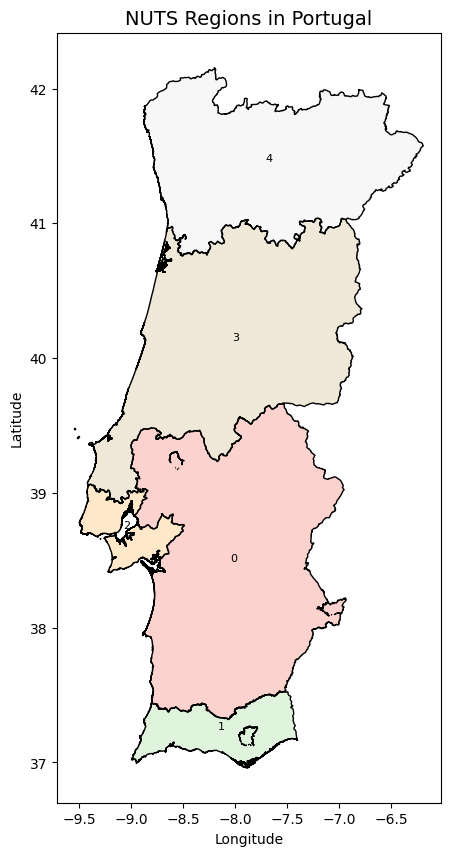

In [62]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Dissolve municipalities by NUTS_NAME to create borders for NUTS regions
nuts_gdf = mun_gdf.dissolve(by='NUTS_NAME').reset_index()

# Plot the dissolved NUTS regions
fig, ax = plt.subplots(figsize=(10, 10))
nuts_gdf.boundary.plot(ax=ax, color='black', linewidth=1)  # Plot NUTS borders
nuts_gdf.plot(ax=ax, column='NUTS_NAME', cmap='Pastel1', alpha=0.6)  # Fill regions with colors

# Add labels for NUTS regions
for idx, row in nuts_gdf.iterrows():
    ax.annotate(
        text=idx, 
        xy=row.geometry.centroid.coords[0], 
        ha='center', 
        fontsize=8, 
        color='black'
    )

# Customize the plot
ax.set_title('NUTS Regions in Portugal', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()